In [1]:
import os
import sys
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from RxDesign.designUtil import cut_polygon_by_line, generate_continue_region, generate_split_line, find_nearest_point
import matplotlib.pyplot as plt
from shapely.geometry import shape
import json
from util import read_sensing_info, plotPolygons, plotLines
from osgeo import gdal
from scipy.ndimage import binary_dilation
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import mplcursors
from ipywidgets import *
from shapely.ops import linemerge
from shapely.geometry import LineString

In [2]:
# LANDFIRE
wf_filename = "/Users/zongrunli/Desktop/Wildfire_GA/data/GRSM_MAIN_WF.json"
with open(wf_filename) as f:
    data = json.load(f)
polygon = shape(data["perimeter"])


landfire_file = "/Users/zongrunli/Desktop/Wildfire_GA/data/geo_static/Slope_Clipped.tif"
landfire_ds = gdal.Open(landfire_file, gdal.GA_ReadOnly)
slope_value = landfire_ds.ReadAsArray()
slope_info = read_sensing_info(landfire_ds)
lon, lat = slope_info["crs"](slope_info["X"], slope_info["Y"], inverse=True)
slope_value = slope_value.astype(float)
original_slope_value = slope_value.copy()
original_slope_value[original_slope_value > 100] = np.nan
# change slope_value to mask
threshold = 20
slope_value[slope_value <= threshold] = 1
slope_value[slope_value > threshold] = 0

# dilation the image
k = np.ones((3, 3), dtype=int)
slope_value = slope_value.astype(int)
slope_value = binary_dilation(slope_value == 0, k) & slope_value

<ipython-input-3-cc53b46c071c>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(lon, lat, original_slope_value)


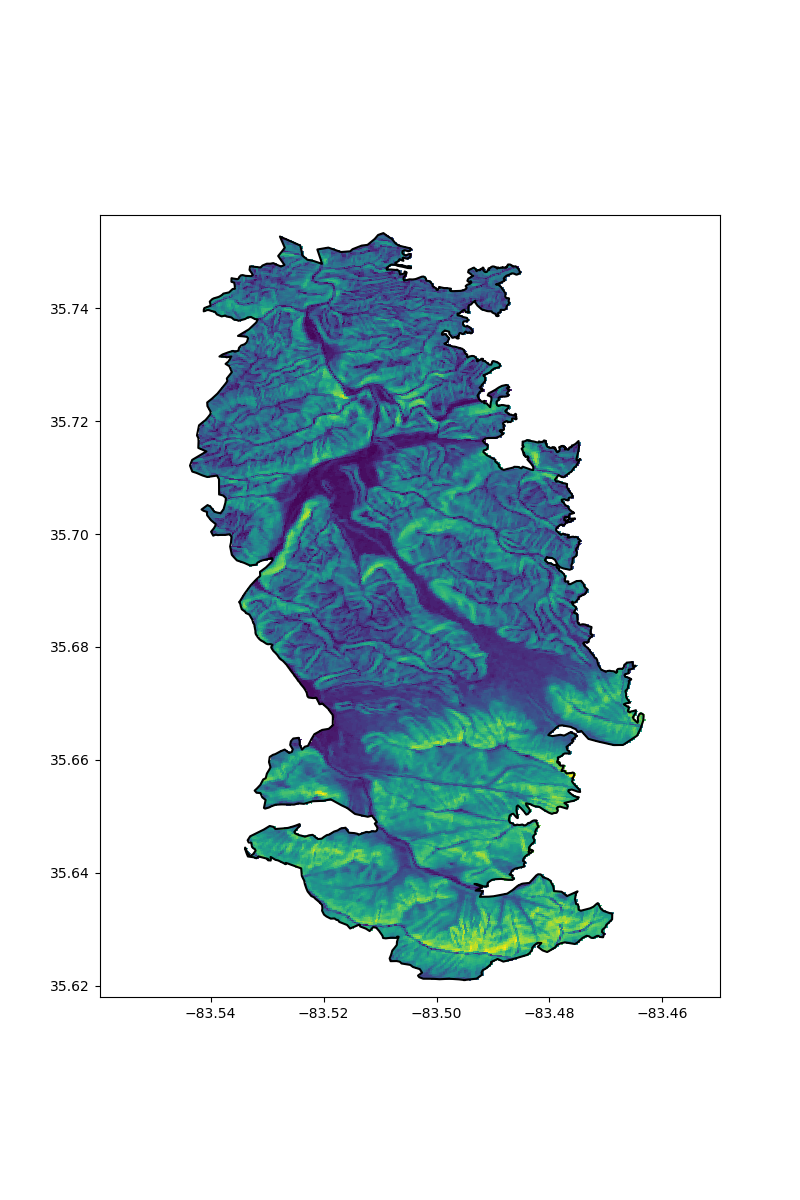

In [3]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 12))
lines_end_points = []
# wildfire
plt.pcolor(lon, lat, original_slope_value)
plotPolygons([polygon], ax, "black")
ax.ticklabel_format(style='plain', useOffset=False)


def on_click(event):
    # Get the x and y coordinates of the click
    x_click = event.xdata
    y_click = event.ydata
    
    # Add the clicked point to the plot
    ax.scatter([x_click], [y_click], c='r', s=3)
    lines_end_points.append((x_click, y_click))
    # Refresh the plot
    fig.canvas.draw()

ax.set_aspect('equal')
# Connect the event handler to the figure
fig.canvas.mpl_connect('button_press_event', on_click)

# Show the interactive plot
plt.show()

In [4]:
print(lines_end_points)

[(-83.50338322769738, 35.69195015060622), (-83.50161181802204, 35.69159586867115), (-83.49877756254149, 35.691064445768546), (-83.49576616609342, 35.68964731802827), (-83.49257762867781, 35.688230190288), (-83.48655483578165, 35.68734448545033), (-83.48372058030111, 35.68893875415814), (-83.48177202965823, 35.69301299641142), (-83.4815948886907, 35.694430124151694), (-83.48070918385304, 35.69531582898936)]


In [5]:
lines = []
# use the end points to create lines
for i in range(0, len(lines_end_points) - 1):
    start_point = lines_end_points[i]
    end_point = lines_end_points[i + 1]
    start_lon = start_point[0]
    start_lat = start_point[1]
    end_lon = end_point[0]
    end_lat = end_point[1]
    
    # find the start and end point
    start_x_idx, start_y_idx = find_nearest_point(start_lon, start_lat, lon, lat, slope_value)
    end_x_idx, end_y_idx = find_nearest_point(end_lon, end_lat, lon, lat, slope_value)
    cur_line_res = generate_split_line(start_x_idx, start_y_idx, end_x_idx, end_y_idx, lon, lat, slope_value)
    if cur_line_res is None:
        print("A not continuous path")
        cur_line_res = LineString([(lon[start_x_idx, start_y_idx], lat[start_x_idx, start_y_idx]),
                                  (lon[end_x_idx, end_y_idx], lat[end_x_idx, end_y_idx])])
    # add head and tail, this part order is important
    if i == 0:
        lines.append(LineString([(start_lon, start_lat),
                                  (lon[start_x_idx, start_y_idx], lat[start_x_idx, start_y_idx])]))
    lines.append(cur_line_res)
    if i == (len(lines_end_points) - 2):
        lines.append(LineString([(lon[end_x_idx, end_y_idx], lat[end_x_idx, end_y_idx]), 
                                 (end_lon, end_lat)]))
merged_line = linemerge(lines)

Path Not Found
A not continuous path
Path Not Found
A not continuous path


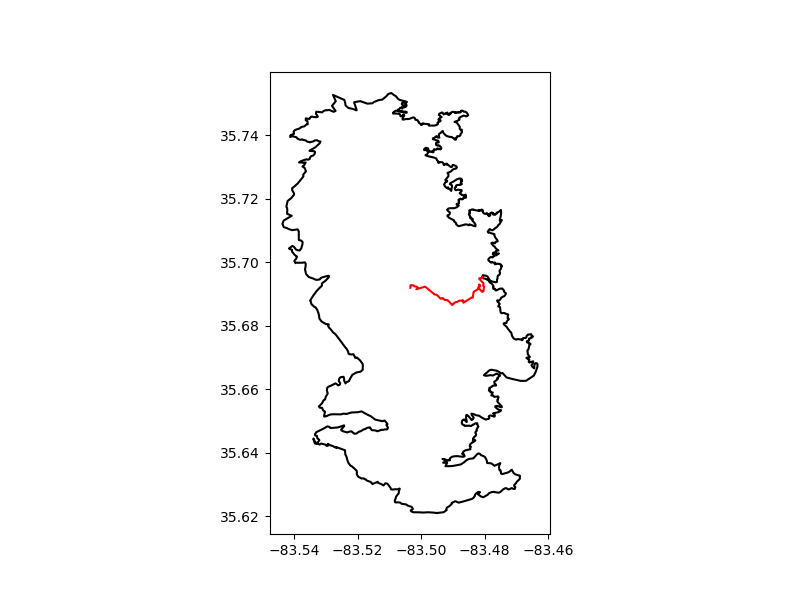

In [6]:
# visualize line
fig, ax = plt.subplots(figsize=(8, 6))
plotPolygons([polygon], ax, 'black')
plotLines([merged_line], ax, 'red')
ax.set_aspect('equal')
plt.show()

In [7]:
print(merged_line)

LINESTRING (-83.50338322769738 35.69195015060622, -83.50332259479624 35.69278383260764, -83.502991038898 35.69274869715629, -83.50265948330576 35.69271356077709, -83.50232792801951 35.69267842347008, -83.50204022944659 35.69237763725195, -83.50170867590886 35.69234249820433, -83.50137712267714 35.69230735822886, -83.50108942926222 35.69200656961326, -83.50113328846693 35.69174092182707, -83.50150869688187 35.69151041452533, -83.49868084006904 35.69229185185775, -83.49571636222836 35.68981515816283, -83.49538482276731 35.68978000136438, -83.49505328361241 35.6897448436382, -83.49476562486011 35.68944403905429, -83.49447796838052 35.68914323369872, -83.49419031417364 35.68884242757152, -83.49390266223944 35.68854162067257, -83.49357112916074 35.68850645876768, -83.49319571152861 35.68873694151178, -83.49290806392194 35.68843613217468, -83.49262041858789 35.68813532206592, -83.4922888878703 35.68810015656507, -83.49195735745893 35.68806499013652, -83.49162582735376 35.68802982278024, -83.

In [8]:
import pickle
# save the line
filename = "/Users/zongrunli/Desktop/Wildfire_GA/RxDesign/temp_lines/line_slope_58.pickle"
res = {"line": merged_line}
with open(filename, 'wb') as handle:
    pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)